<a href="https://colab.research.google.com/github/Mayank-004/Trend-prediction-using-Binance-API/blob/main/EAI_6010_Final_Project_Binance_(ADA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# Download Python Binance Library (uncomment next 2 liens if library not already installed)

import sys
!{sys.executable} -m pip install python-binance

import binance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,accuracy_score
import seaborn as sns
import random
import time
random.seed(786)

In [48]:
# Binance API key and secret key
binance_api='g4hg1wOj6QP1lq0SavNegKi2zlRsjPEWJbGcKo7SABQCtEENmadsRdW4ZHR676Yv'
binance_secret='0W1uLsUY7H5VqfFRydvNSB2S7I2KlGFULRDKHGklhlfmsQhOJTKzCeXO5MOQ8ldp'

In [49]:
# Initialize Binance API
client = binance.Client(binance_api, binance_secret)

In [50]:
# Pull k-line historical data for ADA
START = '1609459200' # Start string - Jan 1 2020 (Beginning of the year until now of historical data)
k_line_type = binance.enums.HistoricalKlinesType.SPOT
ADA_SYMBOL = 'ADAUSDT'
KLINE_INTERVAL = '12h'
hist_data = client.get_historical_klines(symbol=ADA_SYMBOL,interval=KLINE_INTERVAL,start_str=START,klines_type=k_line_type)

In [ ]:
hist_data

## Example Format for hist_data
  [<br>
    1499040000000,      # Open time 
    <br>
    0.01634790,       # Open
    <br>
    0.80000000,       # High 
    <br>
    0.01575800,       # Low 
    <br>
    0.01577100,       # Close 
    <br>
    148976.11427815,  # Volume 
    <br>
    1499644799999,      # Close time
    <br>
    2434.19055334,    # Quote asset volume
    <br>
    308,                # Number of trades 
    <br>
    1756.87402397,    # Taker buy base asset volume 
    <br>
    28.46694368,      # Taker buy quote asset volume
    <br>
    17928899.62484339 # Ignore 
    <br>
  ]
  
 Source: https://sammchardy.github.io/historical-data-download-binance/

In [52]:
# Initialize relevant data into DataFrame to use with model
time = []
open_list = []
high_list = []
low_list = []
close_list = []
trend = [] # 0 for open == close , 1 for open < close, -1 for close > open
next_day_trend = []
for i in range(len(hist_data)-1):
    time.append(datetime.datetime.fromtimestamp(hist_data[i][0]/1000))
    open_list.append(hist_data[i][1])
    high_list.append(hist_data[i][2])
    low_list.append(hist_data[i][3])
    close_list.append(hist_data[i][4])
    if (float(hist_data[i][4])-float(hist_data[i][1])) > 0:
        trend.append(1)
    if (float(hist_data[i][4])-float(hist_data[i][1])) < 0:
#         trend.append(-1)
        trend.append(0)
    if (float(hist_data[i][4])-float(hist_data[i][1])) == 0:
        trend.append(0)
    if (float(hist_data[i+1][4])-float(hist_data[i][4])) > 0:
        next_day_trend.append(1)
    if (float(hist_data[i+1][4])-float(hist_data[i][4])) < 0:
#         next_day_trend.append(-1)
        next_day_trend.append(0)
    if (float(hist_data[i+1][4])-float(hist_data[i][4])) == 0:
        next_day_trend.append(0)
df = pd.DataFrame(list(zip(time, open_list, high_list, low_list, close_list, trend, next_day_trend)),
               columns =['Time','Open', 'High', 'Low', 'Close', 'Single_Day_Trend', 'Two_Day_Trend'])
df.head()

,Time,Open,High,Low,Close,Single_Day_Trend,Two_Day_Trend
0,2021-01-01 00:00:00,0.18134000,0.18473000,0.17673000,0.17950000,0,0
1,2021-01-01 12:00:00,0.17943000,0.18359000,0.17000000,0.17509000,0,0
2,2021-01-02 00:00:00,0.17505000,0.17618000,0.16793000,0.17204000,0,1
3,2021-01-02 12:00:00,0.17207000,0.18457000,0.17026000,0.17742000,1,1
4,2021-01-03 00:00:00,0.17740000,0.19420000,0.17255000,0.18882000,1,1


### Data Visualization

In [53]:
df.dtypes

Time                datetime64[ns]
Open                        object
High                        object
Low                         object
Close                       object
Single_Day_Trend             int64
Two_Day_Trend                int64
dtype: object

In [54]:
#Count Missing Data
missing = df.isna().sum().sort_values(ascending = False)
percent_missing = ((missing / df.isnull().count()) * 100).sort_values(ascending = False)
missing_df = pd.concat([missing,percent_missing], axis = 1, keys = ['Total', 'Percent'],sort = False)
missing_df[missing_df['Total'] >= 1]

,Total,Percent


In [115]:
# checking duplicate values in dataset
duplicate=df[df.duplicated()]
duplicate

,Time,Open,High,Low,Close,Single_Day_Trend,Two_Day_Trend


In [56]:
# checking if dataset is balanced or imbalanced
df['Two_Day_Trend'].value_counts(normalize=True)


1    0.530075
0    0.469925
Name: Two_Day_Trend, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


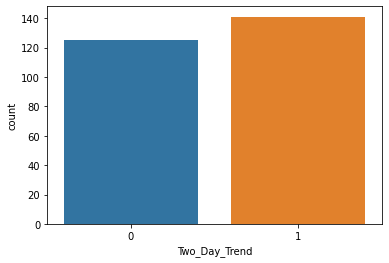

In [57]:
# checking if dataset is balanced or imbalanced

sns.countplot(df['Two_Day_Trend'])


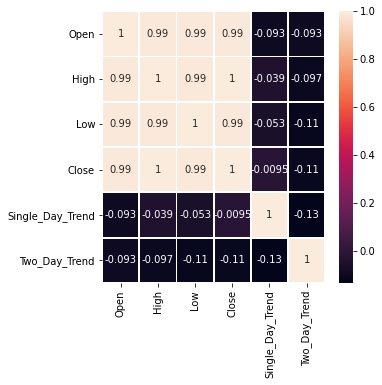

In [116]:
df1=df.copy(deep=True)

# Filtering all Categorical variables
vars_categorical = list(df1.select_dtypes(['object']).columns)

for x in vars_categorical:
    df1.loc[:,x] = df1.loc[:,x].astype(float)


corrMatrix= df1.corr()

fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches

sns.heatmap(corrMatrix, annot=True,linewidth=0.8)
plt.show()

TypeError: ignored

In [118]:
# Split relevant variables into matrices and split into train and test groups
y, X = df['Two_Day_Trend'], [df['High'],df['Low'],df['Close'],df['Single_Day_Trend']]
X_train, X_test, y_train, y_test = train_test_split(np.array(X).T, y, test_size=0.33, random_state=42,stratify=y)

In [119]:

## defining a reusable function to evaluate model performance

def eval_result(model_name,y_train,y_predtrain,y_test,y_predtest):

    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
    from matplotlib import pyplot as plt

    train_accuracy = accuracy_score(y_train, y_predtrain)
    print(f'training data accuracy {train_accuracy}')
    train_roc_auc = roc_auc_score(y_train, y_predtrain) 
    print(f' Area under the ROC curve for training data {train_roc_auc}')
    
    test_accuracy = accuracy_score(y_test, y_predtest)
    print(f'testing data accuracy {test_accuracy}')
    test_roc_auc = roc_auc_score(y_test, y_predtest) 
    print(f' Area under the ROC curve for testing data {test_roc_auc}')
    
    print(classification_report(y_test,y_predtest,digits=5))
    plot_confusion_matrix(model_name, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')
    plot_roc_curve(model_name, X_test, y_test)

  

In [120]:
def run_model(model,verbose=True):
    t0=time.time()
    if verbose== False:
        model.fit(X_train,y_train.ravel(),verbose=0)
    else :
        model.fit(X_train,y_train.ravel())
    
    time_taken= time.time()- t0
    print(f'Time taken: {time_taken}')

# kNN Model

Time taken: 0.0015397071838378906
training data accuracy 1.0
 Area under the ROC curve for training data 1.0
testing data accuracy 0.6136363636363636
 Area under the ROC curve for testing data 0.608718214841723
              precision    recall  f1-score   support

           0    0.59459   0.53659   0.56410        41
           1    0.62745   0.68085   0.65306        47

    accuracy                        0.61364        88
   macro avg    0.61102   0.60872   0.60858        88
weighted avg    0.61214   0.61364   0.61161        88



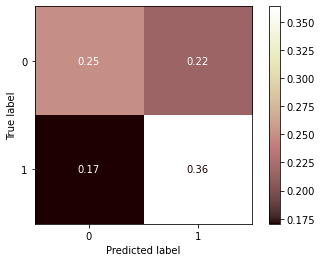

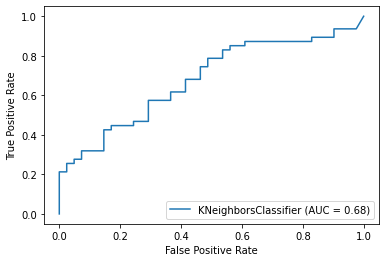

In [121]:
# p = 2 is equivalent to using the euclidean distance
# weights = 'distance' means closer points are weighted more heavily than further away points
n_neighbors = 5
model1 = KNeighborsClassifier(n_neighbors=n_neighbors,weights='distance',algorithm='auto',p=2)
run_model(model1)
y_hat_train = model1.predict(X_train)
y_hat_test = model1.predict(X_test)

eval_result(model1,y_train,y_hat_train,y_test,y_hat_test)


# Random Forest Model

In [ ]:

# Hyperparameter Tuning
# run once

'''from sklearn.ensemble import RandomForestClassifier


n_estimators_hyp = [100,200,300,400,500,700,1000]
min_sample_leaf_hyp = np.linspace(1,20, 20);

oobscore_list=dict()

for i in n_estimators_hyp:
    for j in min_sample_leaf_hyp:
        model2 = RandomForestClassifier(n_estimators=i, min_samples_leaf=int(j), oob_score=True);
        model2.fit(X_train, y_train)
        key = "n_estimator =" +str(i)+" min_sample_leaf ="+str(j);
        oobscore_list[key]=model2.oob_score_

    #oobscore_list.append(rf_model.oob_score_)

oobscore_list'''

Time taken: 0.19179248809814453
Out of bag score for random forest model is:0.42134831460674155
training data accuracy 0.9887640449438202
 Area under the ROC curve for training data 0.9887284701114489
testing data accuracy 0.5568181818181818
 Area under the ROC curve for testing data 0.5539699014011417
              precision    recall  f1-score   support

           0    0.52500   0.51220   0.51852        41
           1    0.58333   0.59574   0.58947        47

    accuracy                        0.55682        88
   macro avg    0.55417   0.55397   0.55400        88
weighted avg    0.55616   0.55682   0.55642        88



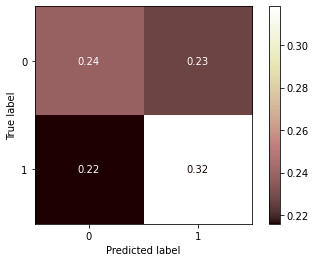

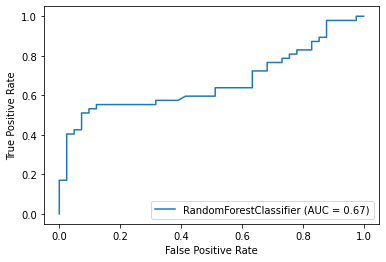

In [124]:
#class_weights = {'Single_Day_Trend':1,'Close':0.85,'High':0.45,'Low':0.45}
model2 = RandomForestClassifier(n_estimators=100,
                                criterion='gini',
                                max_depth=20,
                                min_samples_split=4,
                                min_samples_leaf=1,
                                max_features='auto',
                                oob_score=True,
                                random_state=1234)


run_model(model2)
print(f'Out of bag score for random forest model is:{model2.oob_score_}')



y_hat2 = model2.predict(X_test)

y_hat2_train = model2.predict(X_train)
y_hat2_test = model2.predict(X_test)


eval_result(model2,y_train,y_hat2_train,y_test,y_hat2_test)
